### Create readme.txt file

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import savemat

sys.path.append(os.path.abspath('../helper'))
import config
import utils
import loader
import plotfig
import utils_transfer

In [2]:
source_models_dir  = "../model/static/CNN/BS16/3500_3516/ver14_"
target_data_dir    = "../../CDL Customization/Data/ver29_"

# Min-max Scaler to [-1 1] range
norm_approach = 'minmax'
lower_range = -1
CNN_DropOut = 0.2
CNN_activation = 'Tanh'

# create readme.txt file
content = f"""Generated by file 'transfer/transfer_v3.ipynb'.
Source models were loaded in {source_models_dir},
Target training data are loaded in {target_data_dir}
1000 samples in target dataset (map-based dataset), 0.9 for training, 0.1 for validating
"""

idx_save_path = loader.find_incremental_filename('transferd_model/static/CNN', 'ver', '_', '')
transferd_save_path = f"transferd_model/static/CNN/ver{idx_save_path}_"

os.makedirs(os.path.dirname(f'{transferd_save_path}/readme.txt'), exist_ok=True)

# Write content to readme.txt
with open(transferd_save_path + '/readme.txt', "w") as file:
    file.write(content)

In [3]:
# Straightly applying trained model to target data

In [4]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 50 # 20
learning_rate = 1e-5 # 1e-5
SNR = np.arange(0, 31, 5) # 0:5:30 dB

nmse_LS_LI_val   = []
nmse_LS_NN_val   = []
nmse_LI_NN_val   = []

for snr in SNR:
    print(f" SNR: {snr}/{SNR[-1]}")
    # load target dataset
    [trainLabels, valLabels], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = loader.load_map_data(target_data_dir, device, snr)
            
    # training at target set
    for model_name in ['LS_CNN', 'LS_LI_CNN']:
        print(f'{model_name} model')
        
        if model_name == 'LS_CNN':
            train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_equal_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
            val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_equal_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
            # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                        # of valLabels
            # train_loader, val_loader are already normalized by their own min, max
            # scale to range [0 1] or [-1 1]
            
        elif model_name == 'LS_LI_CNN':
            train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_linear_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
            val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_linear_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
            # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                        # of valLabels
            # train_loader, val_loader are already normalized by their own min, max
            # scale to range [0 1] or [-1 1]
        
        # source model
        model_source = utils.CNN_Est(dropOut=CNN_DropOut, act =CNN_activation).to(device)
        
        checkpoint = torch.load(os.path.join(source_models_dir, f'{snr}dB', f'CNN_1_{model_name}_model.pth'))
        model_source.load_state_dict(checkpoint['model_state_dict'])
        
        model_fineTune = utils_transfer.FineTuneModel(model_source).to(device)
        optimizer = torch.optim.Adam(model_fineTune.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        train_loss =[]
        val_loss = []
        H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
        min_H_true = []
        max_H_true = []
        num_epochs = NUM_EPOCHS
        for epoch in range(num_epochs):
            model_fineTune.train()
            running_loss = 0.0
            if (epoch == num_epochs-1):
                i = 0
            for inputs, targets, targets_min, targets_max in train_loader:
                optimizer.zero_grad()
                outputs = model_fineTune(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
            avg_train_loss = running_loss / len(train_loader)
            train_loss.append(avg_train_loss)
            print(f"SNR: {snr}/{SNR[-1]}, {model_name}, Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
            
            # Validation 
            model_fineTune.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for val_inputs, val_targets, val_targetsMin, val_targetsMax in val_loader:
                    val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
                    val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
                    val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
                    val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
                    
                    val_outputs_real = model_fineTune(val_inputs_real)
                    val_loss_real = criterion(val_outputs_real, val_targets_real)
                    running_val_loss += val_loss_real.item()
                    
                    val_outputs_imag = model_fineTune(val_inputs_imag)
                    val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
                    running_val_loss += val_loss_imag.item()
                    
                    if (epoch == num_epochs-1): # the results after the last training epoch
                        H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                        H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                        
                        i = i+val_outputs_imag.size(0)       
                        
                    
            avg_val_loss = running_val_loss / (len(val_loader)*2)
            val_loss.append(avg_val_loss)    
                    
            print(f"SNR: {snr}/{SNR[-1]}, {model_name}, Val Loss: {avg_val_loss}")
        # end loop epochs
        
        train_save_path = f'{transferd_save_path}/{snr}dB/train'
        os.makedirs(train_save_path, exist_ok=True)
        
        savemat(f'{train_save_path}/{model_name}_loss.mat', {f'val_loss': val_loss, 
                                                            f'train_loss': train_loss})
        
        plotfig.figLoss(train_loss, val_loss, 1, train_save_path, f'_{model_name}_Loss.png')
        
        torch.save({
            'model_state_dict': model_fineTune.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, f'{transferd_save_path}/{snr}dB/{model_name}_model.pth')
        
        
        # Denormalize True Channel
        H_val_true = valLabels.cpu()
        # convert to complex matrices
        H_val_true_complex = torch.complex(H_val_true[:,0,:,:], H_val_true[:,1,:,:])
        # variables['H_val_true'] = H_val_true # (nVal, 2, 612, 14)
        plotfig.figTrueChan(H_val_true[-1,0,:,:], 'True Channel', 1, train_save_path, '_trueChannel.png')
                            # train_save_path = f'transferd_model/static/CNN/ver{idx_save_path}_/{snr}dB/train'

        
        # CNN Estimated Channel                                                               
        H_val_NN_denormd = utils.deNorm(H_NN_val, valLabel_min, valLabel_max, norm_approach, lower_range=lower_range)
                            #     H_NN_val == [nVal, 2, 612, 14] 
                            # valLabel_min == [nVal,1]
        H_val_NN_denormd = H_val_NN_denormd.cpu()
        
        # NMSE of LS (+ LI) + CNN
        H_val_NN_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])# Calculate the NMSE
        nmse_NN = utils.calNMSE(H_val_NN_complex, H_val_true_complex)
            
        if model_name == 'LS_CNN':
            nmse_LS_NN_val.append(nmse_NN.cpu().mean())
            print(f"LS+CNN NMSE: {nmse_NN.cpu().mean()}")
            
            plotfig.figPredChan(H_val_NN_denormd[-1,0,:,:], 'LS+CNN Estimated Channel',
                                    nmse_NN[-1], 1, train_save_path, '_LS_CNN_estimatedChan.png')
                                # train_save_path = f'transferd_model/static/CNN/ver{idx_save_path}_/{snr}dB/train'
        
            # NMSE of Linear Interpolation   # just need to calculate this 1 time  --> calculate at case model_name == 'LS_CNN'
            H_val_linInterp = H_linear_val.cpu()
            # convert to complex matrices
            H_val_linInterp_complex = torch.complex(H_val_linInterp[:,0,:,:], H_val_linInterp[:,1,:,:]) # [?, 612, 14]
            nmse_LI = utils.calNMSE(H_val_linInterp_complex, H_val_true_complex)
            
            nmse_LS_LI_val.append(nmse_LI.cpu().mean())
            print(f"LS+LI NMSE: {nmse_LI.cpu().mean()}")
            
            plotfig.figPredChan(H_val_linInterp[-1,0,:,:], 'LS + Interpolate Estimated Channel',
                                    nmse_LI[-1], 1, train_save_path, '_LS_LI_estimatedChan.png')
                            # train_save_path = f'transferd_model/static/CNN/ver{idx_save_path}_/{snr}dB/train'
                            
        elif model_name == 'LS_LI_CNN':
            nmse_LI_NN_val.append(nmse_NN.cpu().mean())
            print(f"LS+CNN NMSE: {nmse_NN.cpu().mean()}")
            
            plotfig.figPredChan(H_val_NN_denormd[-1,0,:,:], 'LS+LI+CNN Estimated Channel',
                                    nmse_NN[-1], 1, train_save_path, '_LS_LI_CNN_estimatedChan.png')
                                # train_save_path = f'transferd_model/static/CNN/ver{idx_save_path}_/{snr}dB/train'
    
    # end model_phase ['LS_CNN', 'LS_LI_CNN']
# end loop SNR

 SNR: 0/30
LS_CNN model
SNR: 0/30, LS_CNN, Epoch 1/50, Loss: 0.39403218935642925 
SNR: 0/30, LS_CNN, Val Loss: 0.4041551612317562
SNR: 0/30, LS_CNN, Epoch 2/50, Loss: 0.3875897436269692 
SNR: 0/30, LS_CNN, Val Loss: 0.39763205125927925
SNR: 0/30, LS_CNN, Epoch 3/50, Loss: 0.3778821565210819 
SNR: 0/30, LS_CNN, Val Loss: 0.3871381878852844
SNR: 0/30, LS_CNN, Epoch 4/50, Loss: 0.3649186124759061 
SNR: 0/30, LS_CNN, Val Loss: 0.37678904831409454
SNR: 0/30, LS_CNN, Epoch 5/50, Loss: 0.3515024296939373 
SNR: 0/30, LS_CNN, Val Loss: 0.36418914049863815
SNR: 0/30, LS_CNN, Epoch 6/50, Loss: 0.3372502268425056 
SNR: 0/30, LS_CNN, Val Loss: 0.34978199377655983
SNR: 0/30, LS_CNN, Epoch 7/50, Loss: 0.3238975075738771 
SNR: 0/30, LS_CNN, Val Loss: 0.34154950082302094
SNR: 0/30, LS_CNN, Epoch 8/50, Loss: 0.3078131369714226 
SNR: 0/30, LS_CNN, Val Loss: 0.32005830109119415
SNR: 0/30, LS_CNN, Epoch 9/50, Loss: 0.2925285255270345 
SNR: 0/30, LS_CNN, Val Loss: 0.31172238290309906
SNR: 0/30, LS_CNN, Epoc

/home/thien/Hprediction/one_shot_Hest_cleanver/Torch_code/helper/plotfig.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


LS_CNN model
SNR: 15/30, LS_CNN, Epoch 1/50, Loss: 0.37405193011675564 
SNR: 15/30, LS_CNN, Val Loss: 0.39053279906511307
SNR: 15/30, LS_CNN, Epoch 2/50, Loss: 0.3509531148842403 
SNR: 15/30, LS_CNN, Val Loss: 0.3682011440396309
SNR: 15/30, LS_CNN, Epoch 3/50, Loss: 0.3279860370925495 
SNR: 15/30, LS_CNN, Val Loss: 0.3472651168704033
SNR: 15/30, LS_CNN, Epoch 4/50, Loss: 0.30429145800215857 
SNR: 15/30, LS_CNN, Val Loss: 0.32361305318772793
SNR: 15/30, LS_CNN, Epoch 5/50, Loss: 0.2825612636016948 
SNR: 15/30, LS_CNN, Val Loss: 0.29728992097079754
SNR: 15/30, LS_CNN, Epoch 6/50, Loss: 0.2623802947678736 
SNR: 15/30, LS_CNN, Val Loss: 0.2775559797883034
SNR: 15/30, LS_CNN, Epoch 7/50, Loss: 0.2424154364104782 
SNR: 15/30, LS_CNN, Val Loss: 0.25270153768360615
SNR: 15/30, LS_CNN, Epoch 8/50, Loss: 0.2330443598330021 
SNR: 15/30, LS_CNN, Val Loss: 0.23900890722870827
SNR: 15/30, LS_CNN, Epoch 9/50, Loss: 0.21224937295275076 
SNR: 15/30, LS_CNN, Val Loss: 0.22439771331846714
SNR: 15/30, LS_

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [5]:
from torchsummary import summary
summary(model_source, input_size=(1,612,14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1           [-1, 1, 612, 14]               2
            Conv2d-2          [-1, 64, 612, 14]           5,248
              Tanh-3          [-1, 64, 612, 14]               0
            Conv2d-4          [-1, 64, 612, 14]         102,464
              Tanh-5          [-1, 64, 612, 14]               0
           Dropout-6          [-1, 64, 612, 14]               0
            Conv2d-7          [-1, 64, 612, 14]         102,464
              Tanh-8          [-1, 64, 612, 14]               0
            Conv2d-9          [-1, 32, 612, 14]          51,232
             Tanh-10          [-1, 32, 612, 14]               0
          Dropout-11          [-1, 32, 612, 14]               0
           Conv2d-12           [-1, 1, 612, 14]             801
Total params: 262,211
Trainable params: 803
Non-trainable params: 261,408
-----------------------------

In [6]:
summary(model_fineTune, input_size=(1,612,14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1           [-1, 1, 612, 14]               2
            Conv2d-2          [-1, 64, 612, 14]           5,248
              Tanh-3          [-1, 64, 612, 14]               0
            Conv2d-4          [-1, 64, 612, 14]         102,464
              Tanh-5          [-1, 64, 612, 14]               0
           Dropout-6          [-1, 64, 612, 14]               0
            Conv2d-7          [-1, 64, 612, 14]         102,464
              Tanh-8          [-1, 64, 612, 14]               0
            Conv2d-9          [-1, 32, 612, 14]          51,232
             Tanh-10          [-1, 32, 612, 14]               0
          Dropout-11          [-1, 32, 612, 14]               0
           Conv2d-12          [-1, 16, 612, 14]          12,816
             Tanh-13          [-1, 16, 612, 14]               0
           Conv2d-14           [-1, 8, 

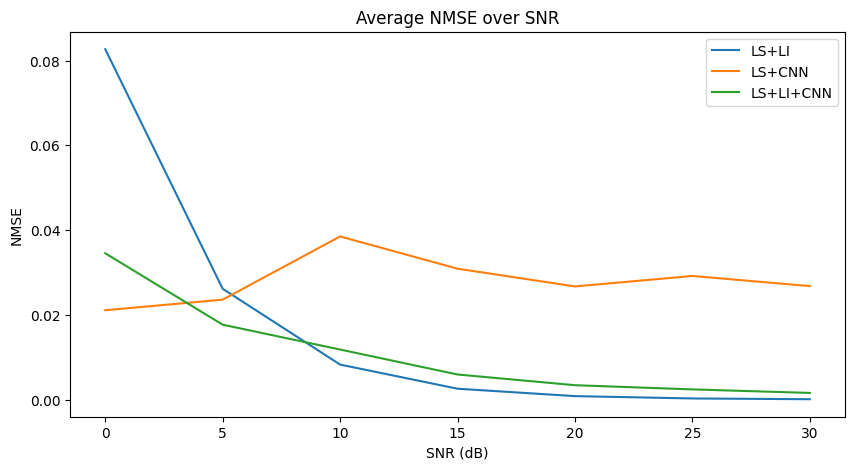

Figure saved at 
transferd_model/static/CNN/ver3_/NMSE1.png


In [7]:
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_LI_val, label='LS+LI')
plt.plot(SNR, nmse_LS_NN_val, label='LS+CNN')
plt.plot(SNR, nmse_LI_NN_val, label='LS+LI+CNN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Average NMSE over SNR')
plt.legend()
plt.savefig(os.path.join(transferd_save_path, "NMSE1.png")) # transferd_save_path = f"transferd_model/static/CNN/ver{idx_save_path}_"
plt.show()
print('Figure saved at ')
print(os.path.join(transferd_save_path, "NMSE1.png"))

savemat(os.path.join(transferd_save_path, 'NMSE.mat'), {'nmse_LS_LI_val': nmse_LS_LI_val, 'nmse_LS_NN_val':nmse_LS_NN_val, 'nmse_LI_NN_val':nmse_LI_NN_val})
